In [1]:
import re
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from numpy.linalg import eigh, eigvalsh
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.covariance import LedoitWolf

# Basic notebook hygiene.
warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 110
pd.set_option("display.max_columns", 50)

# Local data folders used by the rest of the pipeline.
DATA = Path(r"C:\Users\bseis\ABthesis\data")
PROCESSED = DATA / "processed"
ANALYSIS = DATA / "analysis"

# Inputs: precomputed NMI kernel and the matching training-period returns panel.
NMI_FILE = ANALYSIS / "nmi_tier1_asof20180629_k6_min156_sqrt.parquet"

# Training period implied by the kernel naming / construction window.
TRAIN_START = pd.Timestamp("1997-01-01")
TRAIN_END = pd.Timestamp("2018-06-29")

# Core returns file corresponding to that training span (assumes standard naming convention).
CORE_TRAIN_FILE_NAME = f"crsp_weekly_core_{TRAIN_START.date()}_to_{TRAIN_END.date()}.parquet"
CORE_TRAIN_FILE = PROCESSED / CORE_TRAIN_FILE_NAME

# Clustering / diagnostics knobs.
LINKAGE_METHOD_FULL = "ward"
NMI_EDGE_HIGH = 0.2
CORR_EDGE_LOW_ABS = 0.1

# Seed so anything randomized is repeatable.
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)

print(f"NMI File exists: {NMI_FILE.exists()}")
print(f"Core Train File (Expected): {CORE_TRAIN_FILE}")

NMI File exists: True
Core Train File (Expected): C:\Users\bseis\ABthesis\data\processed\crsp_weekly_core_1997-01-01_to_2018-06-29.parquet


In [2]:
def sanitize_kernel(df: pd.DataFrame, name: str = "Q"):
    """Ensure finite, symmetric [0,1], zero-diagonal kernel."""
    if not df.index.equals(df.columns):
        print(f"[{name}] Warning: index != columns. Attempting realignment.")
        common = df.index.intersection(df.columns)
        df = df.loc[common, common]
        
    A = df.to_numpy(dtype="float64", copy=True)
    bad = ~np.isfinite(A)
    if bad.any():
        print(f"[{name}] replacing non-finite entries with 0 →", int(bad.sum()))
        A[bad] = 0.0
    A = np.clip(A, 0.0, 1.0)
    A = 0.5 * (A + A.T)
    np.fill_diagonal(A, 0.0) # NMI kernel diagonal is set to 0
    return pd.DataFrame(A, index=df.index, columns=df.columns)

def cov_to_corr(Sigma: pd.DataFrame) -> pd.DataFrame:
    """Robust conversion of Covariance to Correlation."""
    d = np.sqrt(np.clip(np.diag(Sigma), 0, np.inf))
    with np.errstate(divide='ignore', invalid='ignore'):
        Dinv = np.where(d > 0, 1.0 / d, 0.0)
        Corr = (Sigma.values * Dinv).T * Dinv
    Corr = 0.5 * (Corr + Corr.T)
    np.fill_diagonal(Corr, 1.0) # Correlation kernel diagonal is 1
    return pd.DataFrame(Corr, index=Sigma.index, columns=Sigma.columns)

def vec_upper(dfM: pd.DataFrame) -> np.ndarray:
    """Extract upper triangle elements (excluding diagonal) as a vector."""
    A = dfM.to_numpy()
    iu = np.triu_indices_from(A, k=1)
    v = A[iu]
    return v # Return includes NaNs; filter later if needed.

def effective_rank(eigs: np.ndarray) -> float:
    """Calculate the effective rank (Shannon entropy of the normalized spectrum)."""
    lam = np.asarray(eigs, dtype=float)
    lam = lam[lam > 0]
    if lam.size == 0: return 0.0
    p = lam / lam.sum()
    H = -(p * np.log(p + 1e-16)).sum()
    return float(np.exp(H))

def parse_label_to_ticker_and_permno(label: str):
    """Heuristic parsing of asset labels into Ticker and/or PERMNO."""
    s = str(label).strip()
    ticker, permno = None, None
    
    # Common formats: "TICKER", "TICKER—Company"
    if "—" in s:
        cand = s.split("—")[0].strip().upper()
        if cand and cand.isalpha(): ticker = cand
    elif "-" in s:
         cand = s.split("-")[0].strip().upper()
         if cand and cand.isalpha(): ticker = cand

    # Fallback: assume first token might be ticker if alphabetic
    if ticker is None:
        parts = re.split(r"[ _\-]+", s)
        if parts and parts[0].isalpha() and len(parts[0]) <= 6:
             ticker = parts[0].upper()

    # Look for PERMNO (4-7 digits)
    m = re.search(r"(\d{4,7})", s)
    if m:
        try: permno = int(m.group(1))
        except Exception: permno = None
    
    # Handle cases where the label IS the permno
    if permno is None:
        try: 
            p_candidate = int(s)
            # Basic validation for CRSP permno range
            if 10000 <= p_candidate <= 9999999:
                permno = p_candidate
        except (ValueError, TypeError):
            pass
            
    return ticker, permno

def distance_from_corr(C: pd.DataFrame) -> pd.DataFrame:
    """Convert Correlation to distance metric: sqrt(0.5 * (1 - ρ))."""
    C_clip = C.copy().clip(-1.0, 1.0)
    D = np.sqrt(0.5 * (1.0 - C_clip))
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D.values, 0.0)
    return D

def distance_from_nmi(R: pd.DataFrame) -> pd.DataFrame:
    """Convert NMI to distance metric: sqrt(1 - NMI)."""
    A = np.clip(R.to_numpy(dtype=float), 0.0, 1.0)
    D = np.sqrt(np.maximum(0.0, 1.0 - A))
    D = 0.5 * (D + D.T)
    np.fill_diagonal(D, 0.0)
    return pd.DataFrame(D, index=R.index, columns=R.columns)

def nearest_psd(A: np.ndarray, eps_eig: float = 0.0) -> np.ndarray:
    """Higham-like PSD projection by eigen clipping."""
    A = 0.5*(A + A.T)
    # Use eigh for symmetric matrices
    w, V = eigh(A)
    # Clip negatives
    w = np.maximum(w, eps_eig)
    B = (V * w) @ V.T
    return 0.5*(B + B.T)

In [3]:
# Load the NMI kernel from disk and fail fast if it is missing.
if not NMI_FILE.exists():
    raise FileNotFoundError(f"NMI file not found: {NMI_FILE}")

R_nmi_named = pd.read_parquet(NMI_FILE)

# Clean the kernel right away so everything downstream sees a well-formed matrix.
# This enforces finiteness, symmetry, clipping, and a zero diagonal.
R_nmi_named = sanitize_kernel(R_nmi_named, name="NMI")
names_kernel = list(R_nmi_named.index)

print("Loaded NMI:", NMI_FILE.name)
print("Shape:", R_nmi_named.shape, "| As-of:", TRAIN_END.date())

[NMI] replacing non-finite entries with 0 → 93648
Loaded NMI: nmi_tier1_asof20180629_k6_min156_sqrt.parquet
Shape: (1000, 1000) | As-of: 2018-06-29


In [4]:
def load_training_returns(path: Path, start_date, end_date) -> pd.DataFrame:
    # Load the weekly core panel for the training window, with a fallback to the generic core file.
    if not path.exists():
        generic_path = path.parent / "crsp_weekly_core.parquet"
        if generic_path.exists():
            print(f"Specific core file not found. Using generic: {generic_path.name}")
            path = generic_path
        else:
            raise FileNotFoundError(f"Training core file not found: {path} or generic fallback.")
            
    print(f"Loading returns from: {path.name}")
    df = pd.read_parquet(path).copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["permno"] = pd.to_numeric(df.get("permno"), errors="coerce").astype("Int64")
    if "ticker" in df.columns:
        df["ticker"] = df["ticker"].astype(str).str.upper()
        
    # Restrict to the training window used to build the kernel.
    df = df.loc[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()
    return df

panel_train = load_training_returns(CORE_TRAIN_FILE, TRAIN_START, TRAIN_END)

# Prefer total return when available; otherwise use raw return.
RET_COL = "ret_total" if "ret_total" in panel_train.columns else "ret"
assert RET_COL in panel_train.columns, "No returns column found."

# Build a PERMNO↔ticker map as-of the end date so label resolution is consistent.
snap = (panel_train.loc[:, ["date", "permno", "ticker"]]
        .dropna(subset=["permno", "ticker"])
        .sort_values(["permno", "date"])
        .groupby("permno", observed=True)
        .tail(1))

permno_to_ticker_asof = dict(zip(snap["permno"].astype(int), snap["ticker"]))
ticker_to_permno_asof = dict(zip(snap["ticker"], snap["permno"].astype(int)))

# Resolve kernel labels to a canonical identifier using the as-of maps.
resolved_ids = {}  # kernel_label -> {'permno': P, 'ticker': T}

for lbl in names_kernel:
    t, p = parse_label_to_ticker_and_permno(lbl)

    p_final, t_final = None, None

    # Prefer PERMNO when it matches what we see in the training panel.
    if p is not None and p in permno_to_ticker_asof:
        p_final = p
        t_final = permno_to_ticker_asof[p]
    # Otherwise fall back to ticker match.
    elif t is not None and t in ticker_to_permno_asof:
        t_final = t
        p_final = ticker_to_permno_asof[t]
        
    if p_final is not None:
        resolved_ids[lbl] = {"permno": p_final, "ticker": t_final}

print(f"Aligned {len(resolved_ids)}/{len(names_kernel)} assets.")

# Restrict the kernel to the subset we can confidently align.
aligned_names = list(resolved_ids.keys())
R_nmi_named_aligned = R_nmi_named.loc[aligned_names, aligned_names].copy()

# PERMNO list in the aligned kernel order (used to filter the return panel).
aligned_permnos = [resolved_ids[k]["permno"] for k in aligned_names]

# Pivot the training returns wide using PERMNO as the column key.
tmp = panel_train[["date", "permno", RET_COL]].dropna(subset=["date", "permno"]).copy()
df_ret_pno = (tmp.pivot_table(index="date", columns="permno", values=RET_COL, aggfunc="last")
                 .sort_index()
                 .dropna(how="all")
                 .clip(lower=-0.99, upper=5.0))

# Keep only the PERMNOs that correspond to aligned kernel names.
common_permnos = df_ret_pno.columns.intersection(aligned_permnos)
df_ret_train = df_ret_pno[common_permnos].copy()

# Rename PERMNO columns back to the kernel labels so everything lines up downstream.
pno_to_kernel_label = {v["permno"]: k for k, v in resolved_ids.items()}
df_ret_train.columns = [pno_to_kernel_label[p] for p in df_ret_train.columns]

# Final alignment: enforce identical column/index sets for returns and kernel.
common_assets = df_ret_train.columns.intersection(R_nmi_named_aligned.index)
df_ret_train = df_ret_train[common_assets]
R_nmi_named_aligned = R_nmi_named_aligned.loc[common_assets, common_assets]

print("Training returns shape:", df_ret_train.shape)
print("Aligned NMI shape:", R_nmi_named_aligned.shape)
print("Training window:", df_ret_train.index.min().date(), "→", df_ret_train.index.max().date())

Loading returns from: crsp_weekly_core_1997-01-01_to_2018-06-29.parquet
Aligned 1000/1000 assets.
Training returns shape: (1122, 1000)
Aligned NMI shape: (1000, 1000)
Training window: 1997-01-03 → 2018-06-29


In [5]:
print("\n--- Calculating Stabilized Covariance (Ledoit-Wolf) ---")

# Convert the training return panel to a numpy array for sklearn.
X_train = df_ret_train.to_numpy(dtype=float)

# Ledoit-Wolf doesn't accept NaNs; fill with 0 to keep dimensions intact.
X_train_imp = np.nan_to_num(X_train, nan=0.0).astype(np.float64)

# Estimate a stabilized covariance matrix (useful when p is large relative to T).
# assume_centered=True is reasonable here since weekly returns are close to mean-zero.
try:
    lw = LedoitWolf(assume_centered=True).fit(X_train_imp)
    Sigma_lw_np = lw.covariance_
    shrinkage = lw.shrinkage_
    estimator_name = "Ledoit-Wolf"
    Sigma = pd.DataFrame(Sigma_lw_np, index=df_ret_train.columns, columns=df_ret_train.columns)
except Exception as e:
    print(f"[Warning] Ledoit-Wolf failed ({e}). Falling back to sample covariance.")
    Sigma = df_ret_train.cov(min_periods=1)
    shrinkage = 0.0
    estimator_name = "Sample Covariance"

# Convert covariance to correlation for apples-to-apples comparisons against NMI structure.
Corr_named = cov_to_corr(Sigma)

# Make sure Corr and NMI are on the exact same label set and ordering.
Corr_named = Corr_named.reindex(index=R_nmi_named_aligned.index, columns=R_nmi_named_aligned.index)

print(f"Covariance Estimator: {estimator_name}")
print(f"Shrinkage coefficient: {shrinkage:.4f}")
print("Final aligned shapes NMI:", R_nmi_named_aligned.shape, "| Corr:", Corr_named.shape)


--- Calculating Stabilized Covariance (Ledoit-Wolf) ---
Covariance Estimator: Ledoit-Wolf
Shrinkage coefficient: 0.0398
Final aligned shapes NMI: (1000, 1000) | Corr: (1000, 1000)



--- Analyzing Non-Linearity vs. Gaussian Benchmark ---


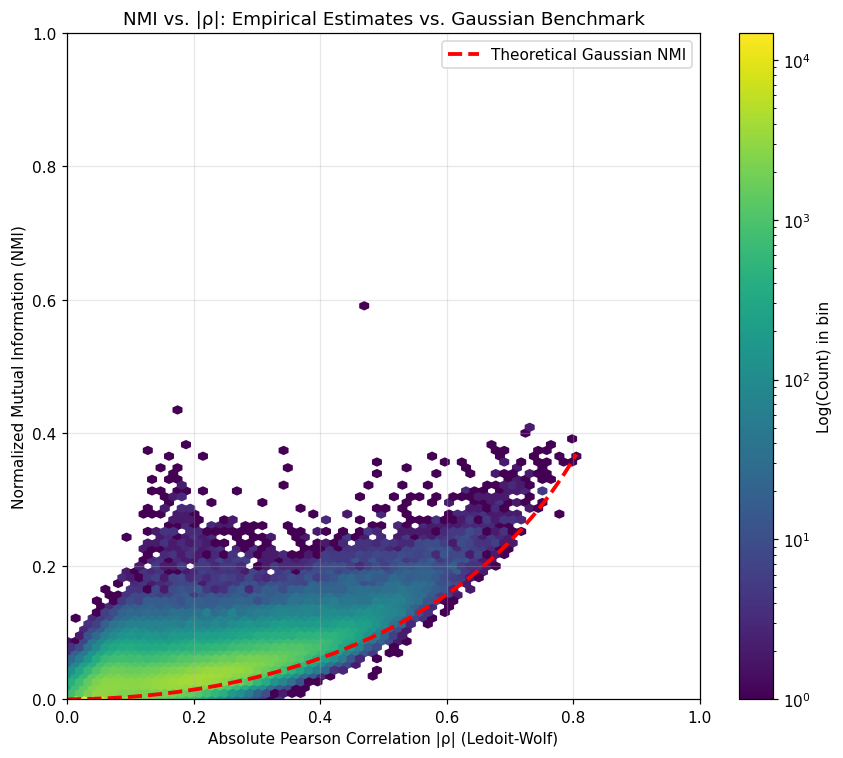

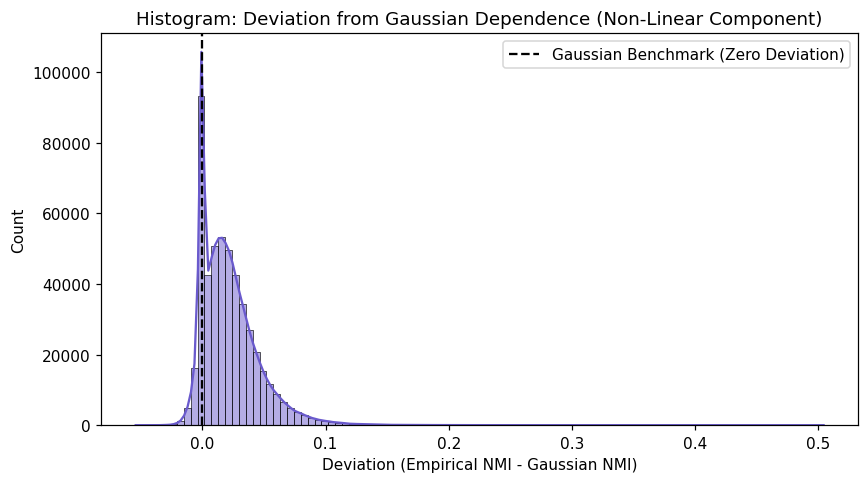

[Deviation Stats] Mean=0.0215, Median=0.0171
  Percentage where Empirical NMI > Gaussian NMI: 78.85%


In [6]:
print("\n--- Analyzing Non-Linearity vs. Gaussian Benchmark ---")

# Map a correlation value to the NMI implied by a bivariate Gaussian model.
# This gives a clean baseline: if dependence were purely Gaussian, empirical NMI
# should sit near this curve as a function of |rho|.
def correlation_to_gaussian_nmi(rho):
    """Theoretical NMI under a bivariate Gaussian model."""
    # Mutual information for a bivariate normal (in nats): I = -0.5 * log(1 - rho^2).
    # Normalize by the differential entropy of a standard normal since the copula step
    # standardizes marginals to ~N(0,1).
    H_std_normal = 0.5 * np.log(2 * np.pi * np.e)

    # Avoid numerical blowups at |rho|=1.
    rho_clipped = np.clip(rho, -0.999999, 0.999999)
    I_nats = -0.5 * np.log(1 - rho_clipped**2)

    return I_nats / H_std_normal

# Gaussian benchmark NMI implied by the stabilized correlation matrix.
GaussNMI_named = correlation_to_gaussian_nmi(Corr_named)

# Match the kernel convention: diagonal is zeroed out.
np.fill_diagonal(GaussNMI_named.values, 0.0)

# Vectorize upper triangles so we can work with pairwise relationships directly.
v_nmi = vec_upper(R_nmi_named_aligned)
v_corr_abs = vec_upper(Corr_named.abs())
v_gauss_nmi = vec_upper(GaussNMI_named)

# Drop any NaNs so plotting and summary stats are well-defined.
mask_finite = np.isfinite(v_nmi) & np.isfinite(v_corr_abs) & np.isfinite(v_gauss_nmi)
v_nmi_f = v_nmi[mask_finite]
v_corr_abs_f = v_corr_abs[mask_finite]
v_gauss_nmi_f = v_gauss_nmi[mask_finite]

# Scatter-density view: empirical NMI vs |rho|, with the Gaussian benchmark overlaid.
plt.figure(figsize=(8, 7))
plt.hexbin(v_corr_abs_f, v_nmi_f, gridsize=60, cmap='viridis', mincnt=1, bins='log')
plt.colorbar(label='Log(Count) in bin')

idx_sort = np.argsort(v_corr_abs_f)
plt.plot(
    v_corr_abs_f[idx_sort],
    v_gauss_nmi_f[idx_sort],
    color='red',
    linewidth=2.5,
    linestyle='--',
    label="Theoretical Gaussian NMI",
)

plt.xlabel("Absolute Pearson Correlation |ρ| (Ledoit-Wolf)")
plt.ylabel("Normalized Mutual Information (NMI)")
plt.title("NMI vs. |ρ|: Empirical Estimates vs. Gaussian Benchmark")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, max(1.0, v_nmi_f.max() * 1.05) if v_nmi_f.size > 0 else 1.0)
plt.tight_layout()
plt.show()

# Deviation from Gaussian benchmark: positive values indicate “more dependence” than
# what a Gaussian model with the same |rho| would imply.
v_deviation_finite = v_nmi_f - v_gauss_nmi_f

plt.figure(figsize=(8, 4.5))
sns.histplot(v_deviation_finite, bins=100, kde=True, color="slateblue")
plt.axvline(0, color="black", lw=1.5, linestyle='--', label='Gaussian Benchmark (Zero Deviation)')
plt.title("Histogram: Deviation from Gaussian Dependence (Non-Linear Component)")
plt.xlabel("Deviation (Empirical NMI - Gaussian NMI)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

print(f"[Deviation Stats] Mean={np.nanmean(v_deviation_finite):.4f}, Median={np.nanmedian(v_deviation_finite):.4f}")
print(f"  Percentage where Empirical NMI > Gaussian NMI: {(v_deviation_finite > 0).mean()*100:.2f}%")


--- Hierarchical Clustering Analysis (ward linkage) ---
Calculating linkages...
Linkages calculated successfully.

Generating Clustermap 1: NMI Kernel (Ordered by NMI)


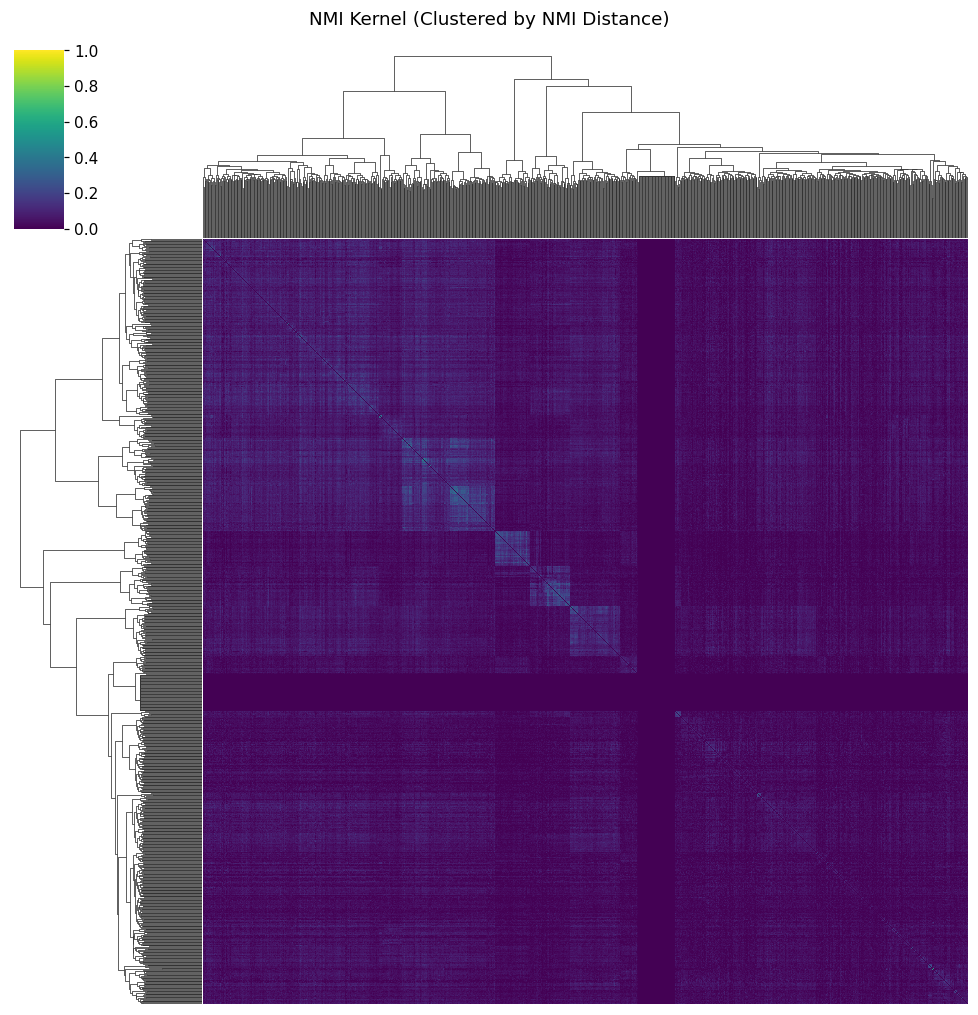


Generating Clustermap 2: Correlation Kernel (Ordered by Correlation)


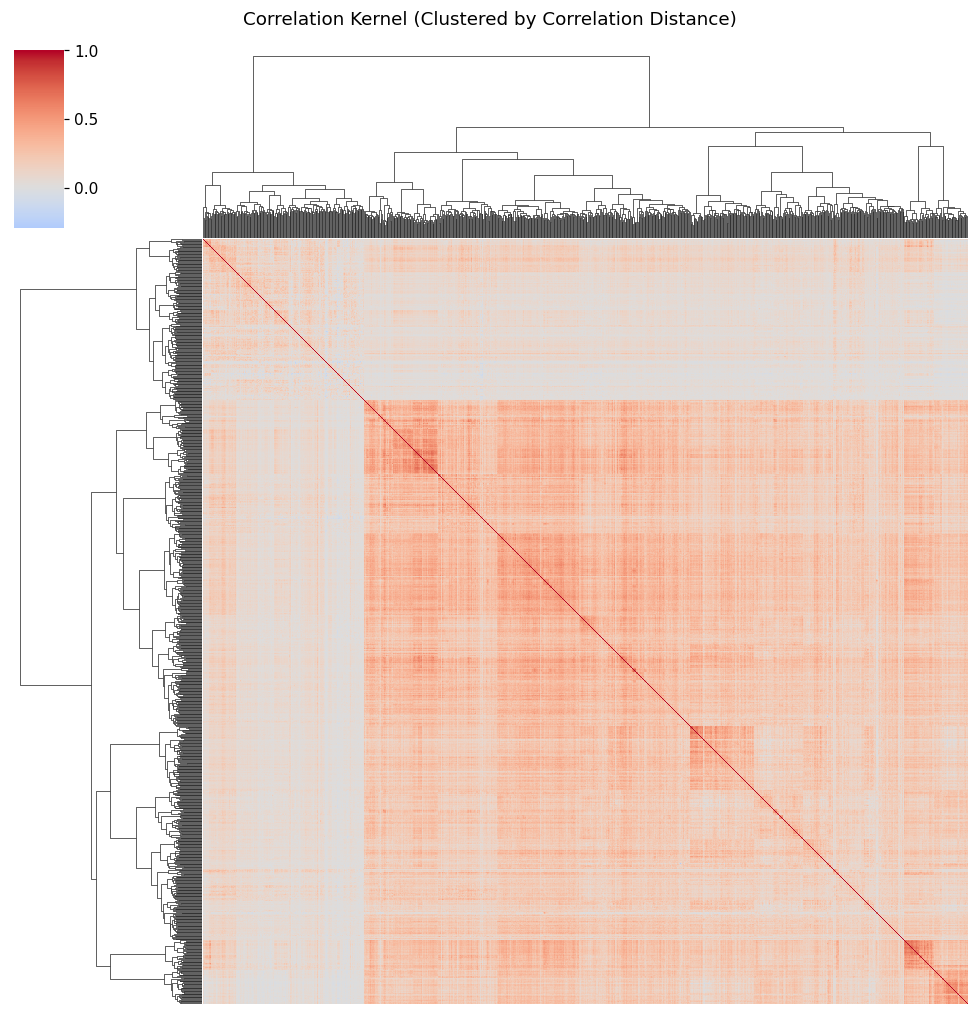


Generating Clustermap 3: Correlation Kernel (Ordered by NMI)


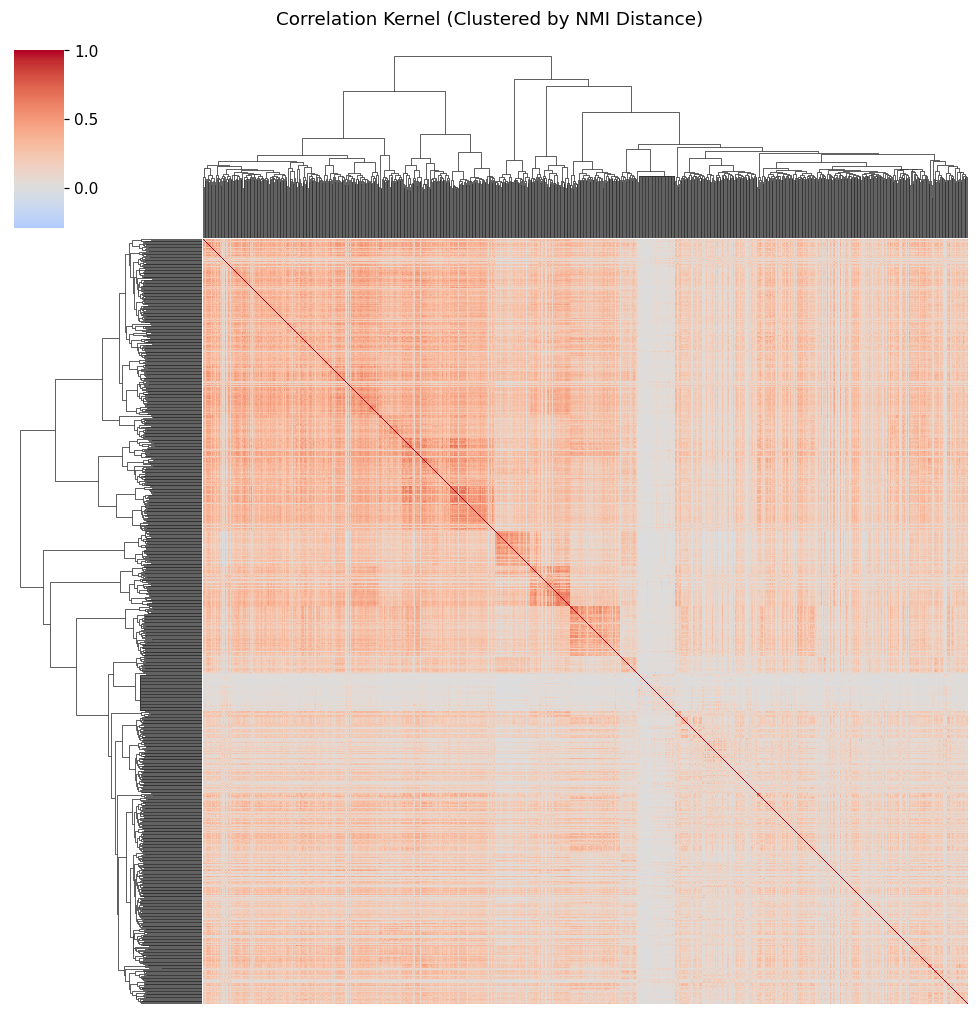


Calculating cluster agreement across different K...


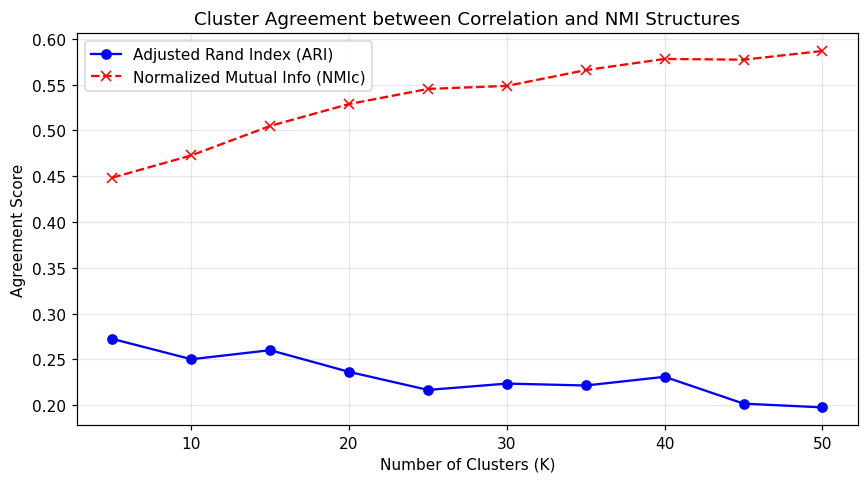

In [8]:
print(f"\n--- Hierarchical Clustering Analysis ({LINKAGE_METHOD_FULL} linkage) ---")

# Build distance matrices from the two dependence measures.
D_corr = distance_from_corr(Corr_named)
D_nmi = distance_from_nmi(R_nmi_named_aligned)

# Linkage needs condensed distance vectors (squareform converts NxN to length N(N-1)/2).
print("Calculating linkages...")

try:
    D_corr_condensed = squareform(D_corr.values, checks=False)
    D_nmi_condensed = squareform(D_nmi.values, checks=False)

    # Guard against any missing distances; treat them as max distance.
    D_corr_condensed = np.nan_to_num(D_corr_condensed, nan=1.0)
    D_nmi_condensed = np.nan_to_num(D_nmi_condensed, nan=1.0)

    Z_corr_full = linkage(D_corr_condensed, method=LINKAGE_METHOD_FULL)
    Z_nmi_full = linkage(D_nmi_condensed, method=LINKAGE_METHOD_FULL)
    print("Linkages calculated successfully.")
    linkage_success = True
except Exception as e:
    print(f"[Error] Linkage failed: {e}. Check for issues in distance matrices.")
    Z_corr_full = Z_nmi_full = None
    linkage_success = False


if linkage_success:
    # Convenience wrapper: clustermap with a precomputed linkage so ordering is consistent.
    def plot_clustermap(Kernel, title, linkage_matrix, cmap="viridis", center=None, vmax=None):
        g = sns.clustermap(
            Kernel,
            row_linkage=linkage_matrix,
            col_linkage=linkage_matrix,
            cmap=cmap,
            center=center,
            vmax=vmax,
            figsize=(9, 9),
            xticklabels=False,
            yticklabels=False,
        )
        g.fig.suptitle(title, y=1.02)
        plt.show()

    # NMI heatmap ordered by NMI-based clustering.
    print("\nGenerating Clustermap 1: NMI Kernel (Ordered by NMI)")
    plot_clustermap(R_nmi_named_aligned, "NMI Kernel (Clustered by NMI Distance)", Z_nmi_full, vmax=1.0)

    # Correlation heatmap ordered by correlation-based clustering.
    print("\nGenerating Clustermap 2: Correlation Kernel (Ordered by Correlation)")
    plot_clustermap(Corr_named, "Correlation Kernel (Clustered by Correlation Distance)", Z_corr_full, cmap="coolwarm", center=0, vmax=1.0)

    # Cross-ordering: show correlation structure under the NMI clustering ordering.
    print("\nGenerating Clustermap 3: Correlation Kernel (Ordered by NMI)")
    plot_clustermap(Corr_named, "Correlation Kernel (Clustered by NMI Distance)", Z_nmi_full, cmap="coolwarm", center=0, vmax=1.0)

    # Compare flat clusterings across different K to see how similar the partitions are.
    k_range = range(5, 51, 5)
    agreement_scores = []

    print("\nCalculating cluster agreement across different K...")
    for k in k_range:
        labels_corr = fcluster(Z_corr_full, k, criterion="maxclust")
        labels_nmi = fcluster(Z_nmi_full, k, criterion="maxclust")
        ari = adjusted_rand_score(labels_corr, labels_nmi)
        nmic = normalized_mutual_info_score(labels_corr, labels_nmi)
        agreement_scores.append({"K": k, "ARI": ari, "NMIc": nmic})

    df_agreement = pd.DataFrame(agreement_scores)

    plt.figure(figsize=(8, 4.5))
    plt.plot(df_agreement["K"], df_agreement["ARI"], 'bo-', label='Adjusted Rand Index (ARI)')
    plt.plot(df_agreement["K"], df_agreement["NMIc"], 'rx--', label='Normalized Mutual Info (NMIc)')
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Agreement Score")
    plt.title("Cluster Agreement between Correlation and NMI Structures")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


--- Analysis of Discordant Pairs (High NMI, Low Correlation) ---
Found 1 pairs with NMI >= 0.2 and |Corr| <= 0.1
Top 15 Discordant Pairs:


asset_i  asset_j       NMI    |corr|
0    14889    83862  0.244299  0.099139

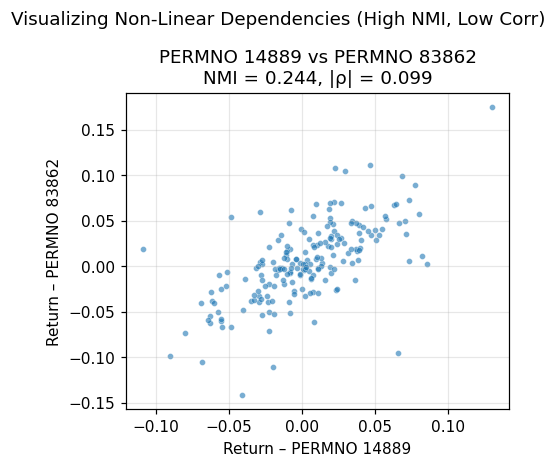

In [10]:
print(f"\n--- Analysis of Discordant Pairs (High NMI, Low Correlation) ---")

# Look for pairs where NMI is meaningfully high but linear correlation is still small.
A_nmi = R_nmi_named_aligned.to_numpy(dtype=float)
A_corr_abs = Corr_named.abs().to_numpy(dtype=float)

R_mask = (A_nmi >= NMI_EDGE_HIGH)
C_mask = (A_corr_abs <= CORR_EDGE_LOW_ABS)

# Only scan the upper triangle so each pair appears once.
mask = np.triu(R_mask & C_mask, k=1)
rows, cols = np.where(mask)

pairs = []
for i, j in zip(rows, cols):
    if i < len(R_nmi_named_aligned.index) and j < len(R_nmi_named_aligned.columns):
        pairs.append(
            (
                R_nmi_named_aligned.index[i],
                R_nmi_named_aligned.columns[j],
                float(A_nmi[i, j]),
                float(A_corr_abs[i, j]),
            )
        )

# Sort by NMI so the strongest non-linear-looking pairs rise to the top.
pairs_sorted = sorted(pairs, key=lambda t: -t[2])
df_pairs = pd.DataFrame(pairs_sorted, columns=["asset_i", "asset_j", "NMI", "|corr|"])

print(f"Found {len(df_pairs)} pairs with NMI >= {NMI_EDGE_HIGH} and |Corr| <= {CORR_EDGE_LOW_ABS}")
print("Top 15 Discordant Pairs:")
display(df_pairs.head(15))

# Spot-check a handful of these pairs in the raw return space.
N_PAIRS_TO_PLOT = min(4, len(df_pairs))
if N_PAIRS_TO_PLOT > 0:
    fig, axes = plt.subplots(1, N_PAIRS_TO_PLOT, figsize=(4.5 * N_PAIRS_TO_PLOT, 4), squeeze=False)
    for k in range(N_PAIRS_TO_PLOT):
        row = df_pairs.iloc[k]
        asset_i, asset_j = row["asset_i"], row["asset_j"]
        ax = axes[0, k]

        # Only plot if both names exist in the training return panel.
        if asset_i in df_ret_train.columns and asset_j in df_ret_train.columns:
            sns.scatterplot(
                x=df_ret_train[asset_i],
                y=df_ret_train[asset_j],
                ax=ax,
                alpha=0.6,
                s=15,
            )

            # Keep the titles compact; labels are often long.
            label_i = f"PERMNO {int(asset_i)}"
            label_j = f"PERMNO {int(asset_j)}"

            ax.set_title(
                f"{label_i} vs {label_j}\n"
                f"NMI = {row['NMI']:.3f}, |ρ| = {row['|corr|']:.3f}"
            )
            ax.set_xlabel(f"Return – {label_i}")
            ax.set_ylabel(f"Return – {label_j}")
            ax.grid(alpha=0.3)
        else:
            ax.set_title(f"Data missing for\n{asset_i} or {asset_j}")

    plt.tight_layout()
    plt.suptitle("Visualizing Non-Linear Dependencies (High NMI, Low Corr)", y=1.05)
    plt.show()
else:
    print("No significantly discordant pairs found at current thresholds.")


--- Eigenvalue Spectrum Analysis (on PSD Kernels) ---
Projecting NMI kernel to nearest PSD (Higham's method)...

[Effective Rank (PSD Kernels)]
  Correlation (C_psd): 212.0
  NMI (Q_psd):         123.8
  (Interpretation: A lower effective rank suggests information is concentrated in fewer dimensions.)


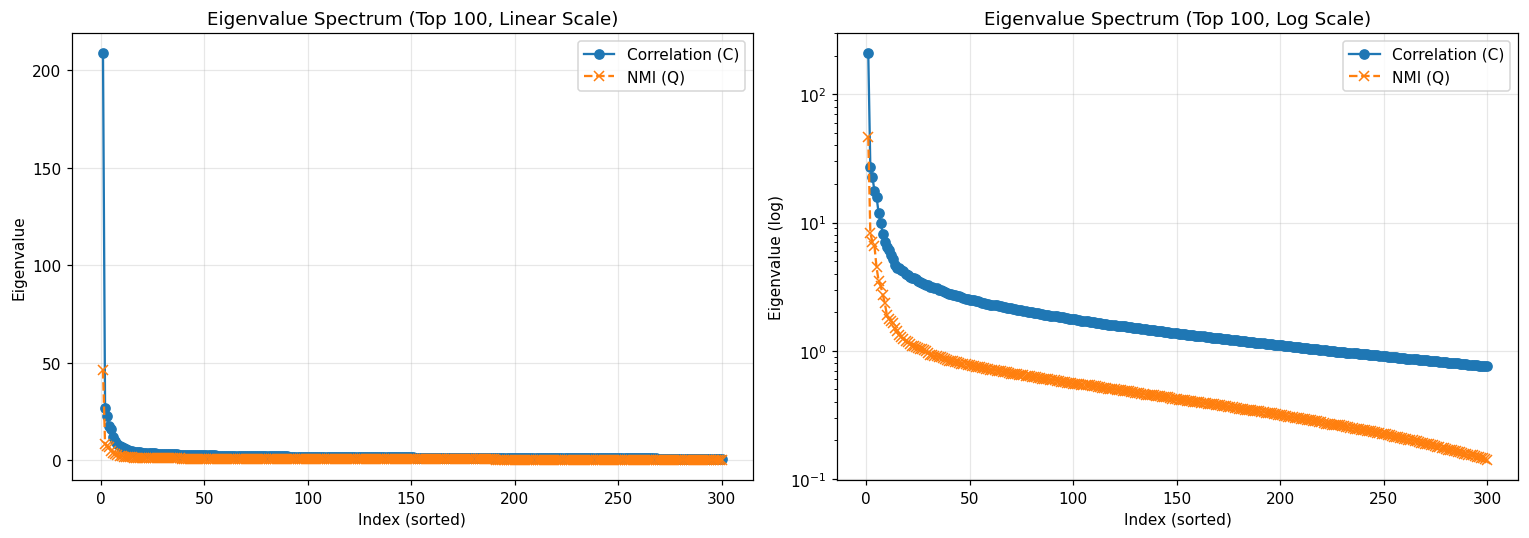


[Concentration] Components needed for 80% explanation:
  Correlation: 292 | NMI: 153


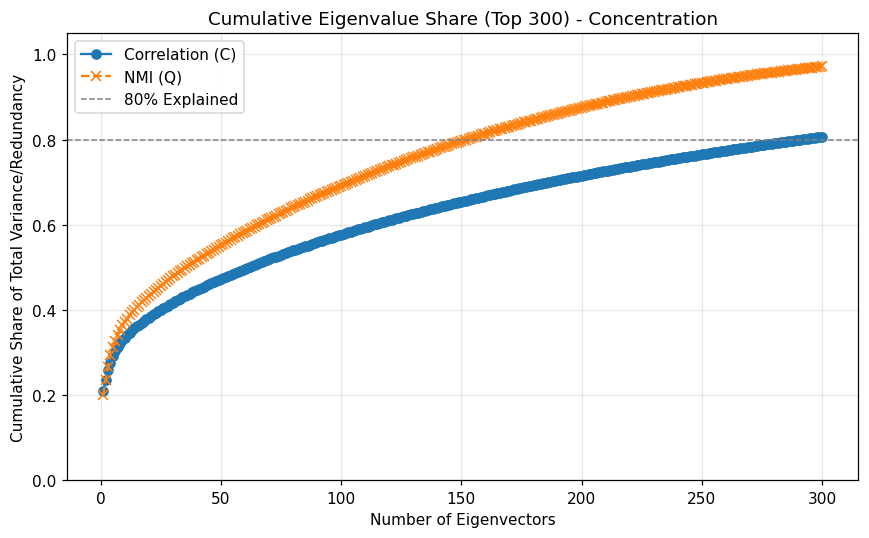

In [12]:
print(f"\n--- Eigenvalue Spectrum Analysis (on PSD Kernels) ---")

# NMI kernels are not guaranteed PSD, so project before doing any spectral diagnostics.
Q_np_raw = R_nmi_named_aligned.to_numpy(dtype=float)
print("Projecting NMI kernel to nearest PSD (Higham's method)...")
Q_psd = nearest_psd(Q_np_raw, eps_eig=0.0)

# Correlation should already be PSD (especially under Ledoit-Wolf), but enforce symmetry anyway.
C_psd = Corr_named.to_numpy(dtype=float)
C_psd = 0.5 * (C_psd + C_psd.T)

# Eigenvalues for symmetric matrices (sorted descending).
eig_Q = np.sort(eigvalsh(Q_psd))[::-1]
eig_C = np.sort(eigvalsh(C_psd))[::-1]

# Drop tiny/negative numerical junk before computing effective ranks.
EIG_TOL = 1e-9
eig_Q = eig_Q[eig_Q > EIG_TOL]
eig_C = eig_C[eig_C > EIG_TOL]

# Effective rank is a quick “how many dimensions matter” summary.
er_Q = effective_rank(eig_Q)
er_C = effective_rank(eig_C)

print(f"\n[Effective Rank (PSD Kernels)]")
print(f"  Correlation (C_psd): {er_C:.1f}")
print(f"  NMI (Q_psd):         {er_Q:.1f}")
print(f"  (Interpretation: lower effective rank means more mass concentrated in fewer modes.)")

# Plot the leading part of each spectrum.
KMAX = 300

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, min(KMAX, len(eig_C))+1), eig_C[:KMAX], "o-", label="Correlation (C)")
axes[0].plot(range(1, min(KMAX, len(eig_Q))+1), eig_Q[:KMAX], "x--", label="NMI (Q)")
axes[0].set_title("Eigenvalue Spectrum (Top 100, Linear Scale)")
axes[0].set_xlabel("Index (sorted)")
axes[0].set_ylabel("Eigenvalue")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].semilogy(range(1, min(KMAX, len(eig_C))+1), eig_C[:KMAX], "o-", label="Correlation (C)")
axes[1].semilogy(range(1, min(KMAX, len(eig_Q))+1), eig_Q[:KMAX], "x--", label="NMI (Q)")
axes[1].set_title("Eigenvalue Spectrum (Top 100, Log Scale)")
axes[1].set_xlabel("Index (sorted)")
axes[1].set_ylabel("Eigenvalue (log)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cumulative share: how quickly the spectrum concentrates.
cum_C = np.cumsum(eig_C) / np.sum(eig_C)
cum_Q = np.cumsum(eig_Q) / np.sum(eig_Q)

try:
    k_80_C = np.where(cum_C >= 0.8)[0][0] + 1
    k_80_Q = np.where(cum_Q >= 0.8)[0][0] + 1
    print(f"\n[Concentration] Components needed for 80% explanation:")
    print(f"  Correlation: {k_80_C} | NMI: {k_80_Q}")
except IndexError:
    print("\n[Concentration] Could not determine 80% explanation threshold (check eigenvalues).")

plt.figure(figsize=(8, 5))
plt.plot(range(1, min(KMAX, len(cum_C))+1), cum_C[:KMAX], "o-", label="Correlation (C)")
plt.plot(range(1, min(KMAX, len(cum_Q))+1), cum_Q[:KMAX], "x--", label="NMI (Q)")
plt.axhline(0.8, color="gray", lw=1, ls="--", label="80% Explained")

plt.title("Cumulative Eigenvalue Share (Top 300) - Concentration")
plt.xlabel("Number of Eigenvectors")
plt.ylabel("Cumulative Share of Total Variance/Redundancy")
plt.legend()
plt.grid(alpha=0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()